In [2]:
from itertools import product
import ast

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [44]:
def image_transform(image):
    torchvision_preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    image = torchvision_preprocess(image)
    image = image.reshape(-1)

    return image

train_indices = torch.randperm(60000)[:600]
train_dataset = torch.utils.data.Subset(torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=image_transform), train_indices)
test_indices = torch.randperm(10000)[:100]
test_dataset = torch.utils.data.Subset(torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=image_transform), test_indices)

In [45]:
WIDTH, HEIGHT, CH = 28, 28, 3
CLASSES = 10

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
batch_sizes = [128]
activation_functions = {'ReLU': nn.ReLU(), 'Sigmoid': nn.Sigmoid(), 'Tanh': nn.Tanh(), 'LeakyReLU': nn.LeakyReLU()}
optimizers = {'SGD': optim.SGD, 'Adam': optim.Adam, 'RMSprop': optim.RMSprop}
num_epochs = [10, 30, 50]
early_stopping_patience = [5]
depths = [2, 4, 6]
widths = [32, 128, 512]
dropouts = [0.2, 0.5]
l2_lambdas = [0.001, 0.01]

data_loaders = {}

def get_data_loader(batch_size):
    if batch_size not in data_loaders:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
        data_loaders[batch_size] = (train_loader, test_loader)
    
    return data_loaders[batch_size]

In [40]:
def create_mlp(depth, width, activation_fn, dropout=0.0):
    layers = []
    input_size = HEIGHT * WIDTH
    layers.append(nn.Linear(input_size, width))
    layers.append(activation_fn)

    for _ in range(depth - 1):
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn)

    layers.append(nn.Linear(width, CLASSES))
    return nn.Sequential(*layers)

def train_and_evaluate(depth, width, activation, batch_size, optimizer_name, 
                       lr=0.03, dropout=0.0, l2_lambda=0.0, early_stopping_patience=None, max_epochs=50,
                       verbose=False):
    train_loader, test_loader = get_data_loader(batch_size)
    model = create_mlp(depth, width, activation_functions[activation], dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizers[optimizer_name](model.parameters(), lr=lr, weight_decay=l2_lambda)

    best_acc = 0.0
    min_loss = float('inf')
    patience_counter = 0
    history = []

    for epoch in range(max_epochs):
        model.train()
        correct, total = 0, 0
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
        train_acc = correct / total
        train_loss = running_loss / len(train_loader)

        model.eval()
        correct, total = 0, 0
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()
        test_acc = correct / total
        test_loss = running_loss / len(test_loader)

        history.append((train_acc, train_loss, test_acc, test_loss))
        if verbose:
            print(f"{epoch + 1}: Train Acc {train_acc} Train Loss {train_loss} Test Acc {test_acc} Test Loss {test_loss}")

        if test_acc > best_acc:
            best_acc = test_acc

        if early_stopping_patience:
            if min_loss > test_loss:
                min_loss = test_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    break

    return best_acc, history

In [41]:
def plot_history(history):
    epochs = len(history)
    iterations = range(1, epochs+1)

    _, ax = plt.subplots(1, 2)

    train_acc = [e[0] for e in history]
    ax[0].plot(iterations, train_acc, label="Train Accuracy")

    train_loss = [e[1] for e in history]
    ax[1].plot(iterations, train_loss, label="Train Loss")

    test_acc = [e[2] for e in history] 
    ax[0].plot(iterations, test_acc, label="Test Accuracy")

    test_loss = [e[3] for e in history] 
    ax[1].plot(iterations, test_loss, label="Test Loss")

    ax[0].legend()
    ax[0].set_xlabel("Iterations")
    ax[0].set_ylabel("Accuracy")

    ax[1].legend()
    ax[1].set_xlabel("Iterations")
    ax[1].set_ylabel("Loss")

    plt.show()

1. Select optimal epochs count

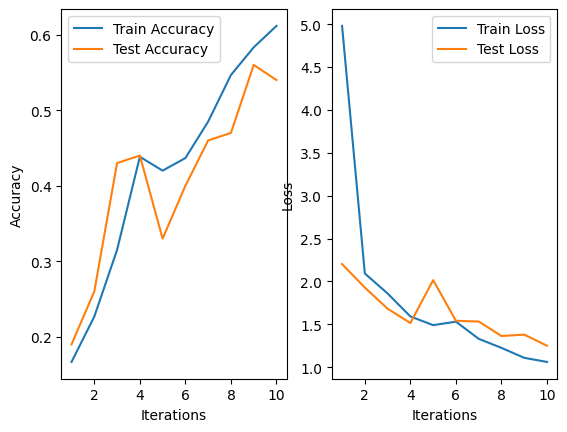

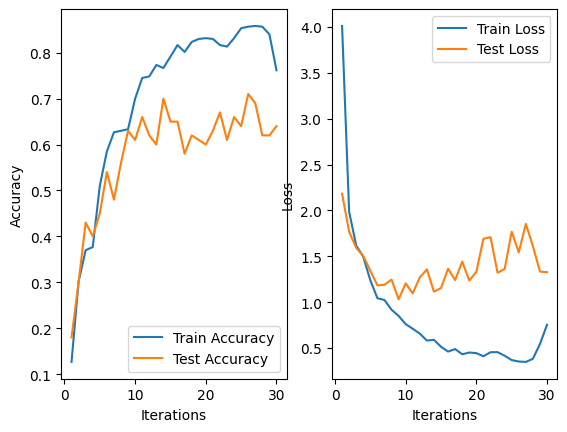

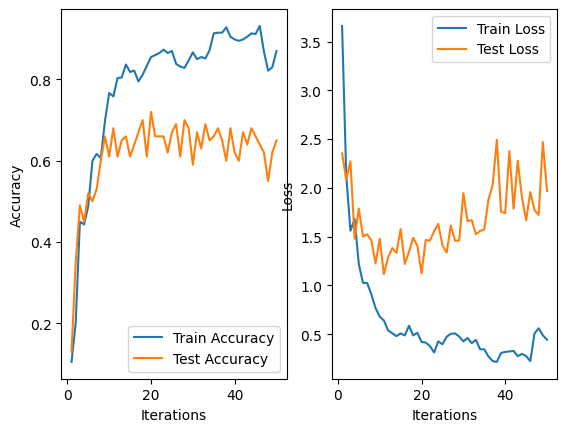

In [ ]:
best_acc = -1
best_n = None

for epochs in num_epochs:
    acc, history = train_and_evaluate(4, 128, 'ReLU', 128, 'Adam', max_epochs=epochs)
    if acc > best_acc:
        best_acc = acc
        best_n = epochs
    
    plot_history(history)

On the median model 30 epochs is just before overfit

In [15]:
num_epochs = [30]

In [17]:
param_grid = product(depths, widths, activation_functions.keys(), batch_sizes, optimizers.keys(), dropouts, l2_lambdas, num_epochs, early_stopping_patience)

results = []
for depth, width, activation, batch_size, optimizer_name, dropout, l2_lambda, epochs, patience in param_grid:
    best_acc, history = train_and_evaluate(depth, width, activation, batch_size, optimizer_name, dropout=dropout, l2_lambda=l2_lambda, early_stopping_patience=patience, max_epochs=epochs)
    res = (depth, width, activation, batch_size, optimizer_name, dropout, l2_lambda, epochs, patience, best_acc, history)
    print(f"Depth: {res[0]}, Width: {res[1]}, Activation: {res[2]}, Batch: {res[3]}, Opt: {res[4]}, Dropout: {res[5]}, L2: {res[6]}, Epochs: {res[7]}, Patience: {res[8]}, Acc: {res[9]:.4f}")
    results.append(res)

Depth: 2, Width: 32, Activation: ReLU, Batch: 128, Opt: SGD, Dropout: 0.2, L2: 0.001, Epochs: 30, Patience: 5, Acc: 0.7400
Depth: 2, Width: 32, Activation: ReLU, Batch: 128, Opt: SGD, Dropout: 0.2, L2: 0.01, Epochs: 30, Patience: 5, Acc: 0.6900
Depth: 2, Width: 32, Activation: ReLU, Batch: 128, Opt: SGD, Dropout: 0.5, L2: 0.001, Epochs: 30, Patience: 5, Acc: 0.6600
Depth: 2, Width: 32, Activation: ReLU, Batch: 128, Opt: SGD, Dropout: 0.5, L2: 0.01, Epochs: 30, Patience: 5, Acc: 0.6900
Depth: 2, Width: 32, Activation: ReLU, Batch: 128, Opt: Adam, Dropout: 0.2, L2: 0.001, Epochs: 30, Patience: 5, Acc: 0.7500
Depth: 2, Width: 32, Activation: ReLU, Batch: 128, Opt: Adam, Dropout: 0.2, L2: 0.01, Epochs: 30, Patience: 5, Acc: 0.6900
Depth: 2, Width: 32, Activation: ReLU, Batch: 128, Opt: Adam, Dropout: 0.5, L2: 0.001, Epochs: 30, Patience: 5, Acc: 0.7200
Depth: 2, Width: 32, Activation: ReLU, Batch: 128, Opt: Adam, Dropout: 0.5, L2: 0.01, Epochs: 30, Patience: 5, Acc: 0.7200
Depth: 2, Width:

1. General analysis (pairplots, correlation) of multicriterion optimization

In [27]:
df = pd.DataFrame(results, columns=['Depth', 'Width', 'Activation', 'Batch', 'Opt', 'Dropout', 'L2', 'Epochs', 'Patience', 'Acc', 'History'])
df.to_csv('data/c_5_lab_1_out.csv', index=False) 

NameError: name 'results' is not defined

In [57]:
df = pd.read_csv('data/c_5_lab_1_out.csv')
df

,Depth,Width,Activation,Batch,Opt,Dropout,L2,Epochs,Patience,Acc,History
0,2,32,ReLU,128,SGD,0.2,0.001,30,5,0.74,"[(0.13666666666666666, 2.2771618366241455, 0.2..."
1,2,32,ReLU,128,SGD,0.2,0.010,30,5,0.69,"[(0.10333333333333333, 2.2958280086517333, 0.1..."
2,2,32,ReLU,128,SGD,0.5,0.001,30,5,0.66,"[(0.12, 2.300979995727539, 0.1, 2.273846864700..."
3,2,32,ReLU,128,SGD,0.5,0.010,30,5,0.69,"[(0.10666666666666667, 2.299656534194946, 0.18..."
4,2,32,ReLU,128,Adam,0.2,0.001,30,5,0.75,"[(0.225, 2.601823568344116, 0.28, 1.9636610746..."
...,...,...,...,...,...,...,...,...,...,...,...
427,6,512,LeakyReLU,128,Adam,0.5,0.010,30,5,0.16,"[(0.115, 2.3423658847808837, 0.08, 3.925520658..."
428,6,512,LeakyReLU,128,RMSprop,0.2,0.001,30,5,0.18,"[(0.07666666666666666, 43577806957.26094, 0.12..."
429,6,512,LeakyReLU,128,RMSprop,0.2,0.010,30,5,0.18,"[(0.11833333333333333, 107273195979.84729, 0.1..."
430,6,512,LeakyReLU,128,RMSprop,0.5,0.001,30,5,0.16,"[(0.105, 1558938374.8603625, 0.08, 1799146.25)..."


In [58]:
df['Activation'] = df['Activation'].astype('category')
df['Opt'] = df['Opt'].astype('category')
df

,Depth,Width,Activation,Batch,Opt,Dropout,L2,Epochs,Patience,Acc,History
0,2,32,ReLU,128,SGD,0.2,0.001,30,5,0.74,"[(0.13666666666666666, 2.2771618366241455, 0.2..."
1,2,32,ReLU,128,SGD,0.2,0.010,30,5,0.69,"[(0.10333333333333333, 2.2958280086517333, 0.1..."
2,2,32,ReLU,128,SGD,0.5,0.001,30,5,0.66,"[(0.12, 2.300979995727539, 0.1, 2.273846864700..."
3,2,32,ReLU,128,SGD,0.5,0.010,30,5,0.69,"[(0.10666666666666667, 2.299656534194946, 0.18..."
4,2,32,ReLU,128,Adam,0.2,0.001,30,5,0.75,"[(0.225, 2.601823568344116, 0.28, 1.9636610746..."
...,...,...,...,...,...,...,...,...,...,...,...
427,6,512,LeakyReLU,128,Adam,0.5,0.010,30,5,0.16,"[(0.115, 2.3423658847808837, 0.08, 3.925520658..."
428,6,512,LeakyReLU,128,RMSprop,0.2,0.001,30,5,0.18,"[(0.07666666666666666, 43577806957.26094, 0.12..."
429,6,512,LeakyReLU,128,RMSprop,0.2,0.010,30,5,0.18,"[(0.11833333333333333, 107273195979.84729, 0.1..."
430,6,512,LeakyReLU,128,RMSprop,0.5,0.001,30,5,0.16,"[(0.105, 1558938374.8603625, 0.08, 1799146.25)..."


In [59]:
target = 'Acc'
df_cleaned = df.drop(['History', 'Batch', 'Patience', 'Epochs'], axis=1)

In [60]:
df_cleaned.sort_values('Acc', ascending=True)[:10]

,Depth,Width,Activation,Opt,Dropout,L2,Acc
326,6,32,LeakyReLU,SGD,0.5,0.001,0.07
325,6,32,LeakyReLU,SGD,0.2,0.010,0.08
387,6,512,ReLU,SGD,0.5,0.010,0.08
339,6,128,ReLU,SGD,0.5,0.010,0.08
146,4,32,ReLU,SGD,0.5,0.001,0.09
291,6,32,ReLU,SGD,0.5,0.010,0.10
423,6,512,LeakyReLU,SGD,0.5,0.010,0.10
422,6,512,LeakyReLU,SGD,0.5,0.001,0.10
420,6,512,LeakyReLU,SGD,0.2,0.001,0.10
207,4,128,Sigmoid,SGD,0.5,0.010,0.10


In [61]:
df_cleaned.sort_values('Acc', ascending=False)[:10]

,Depth,Width,Activation,Opt,Dropout,L2,Acc
120,2,512,Tanh,SGD,0.2,0.001,0.77
97,2,512,ReLU,SGD,0.2,0.010,0.77
121,2,512,Tanh,SGD,0.2,0.010,0.77
72,2,128,Tanh,SGD,0.2,0.001,0.77
52,2,128,ReLU,Adam,0.2,0.001,0.76
16,2,32,Sigmoid,Adam,0.2,0.001,0.76
122,2,512,Tanh,SGD,0.5,0.001,0.76
66,2,128,Sigmoid,Adam,0.5,0.001,0.76
84,2,128,LeakyReLU,SGD,0.2,0.001,0.76
123,2,512,Tanh,SGD,0.5,0.010,0.76


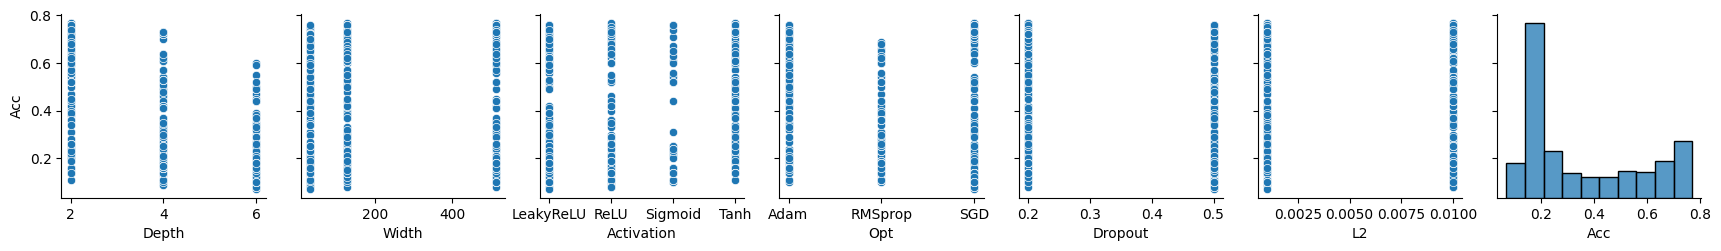

In [62]:
sns.pairplot(df_cleaned, y_vars=['Acc'], x_vars=df_cleaned.columns)
plt.show()

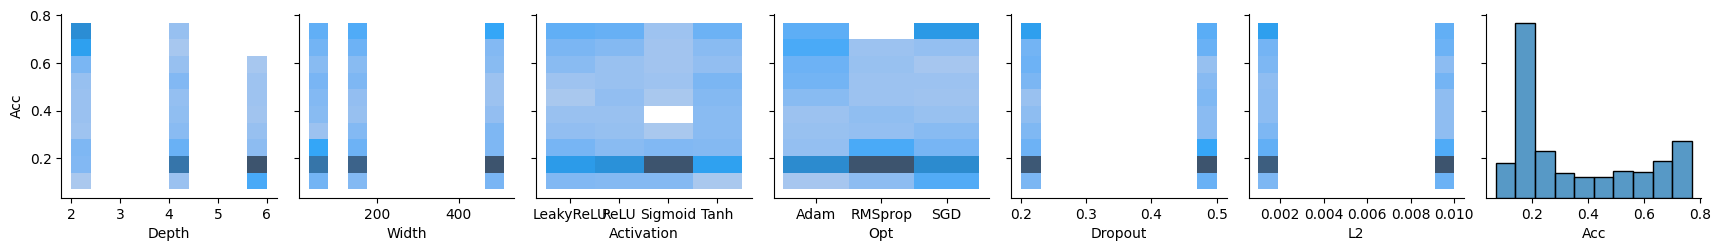

In [63]:
sns.pairplot(df_cleaned, y_vars=['Acc'], x_vars=df_cleaned.columns, kind='hist')
plt.show()

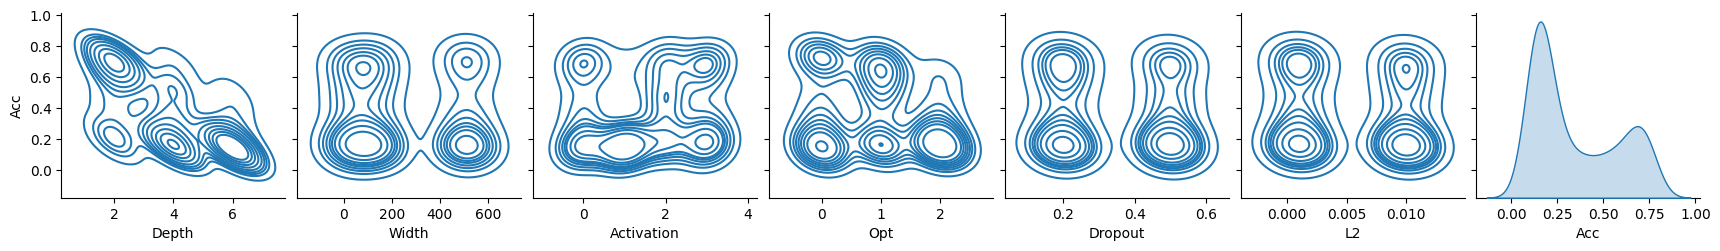

In [64]:
df_numeric = df_cleaned.copy()

df_numeric['Activation'] = pd.factorize(df_numeric['Activation'])[0]
df_numeric['Opt'] = pd.factorize(df_numeric['Opt'])[0]

sns.pairplot(df_numeric, y_vars=['Acc'], x_vars=df_numeric.columns, kind='kde')
plt.show()

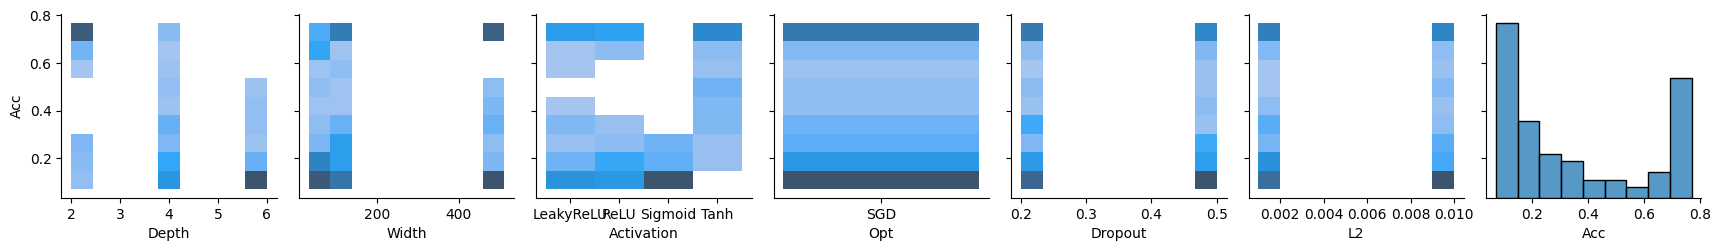

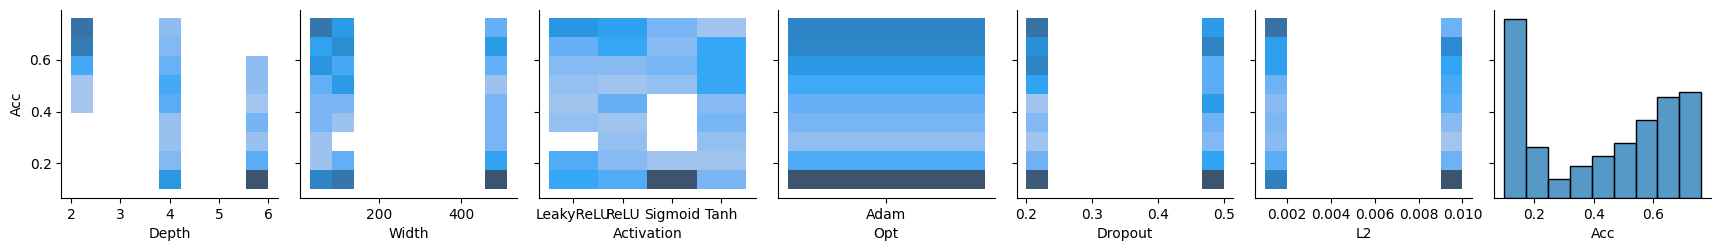

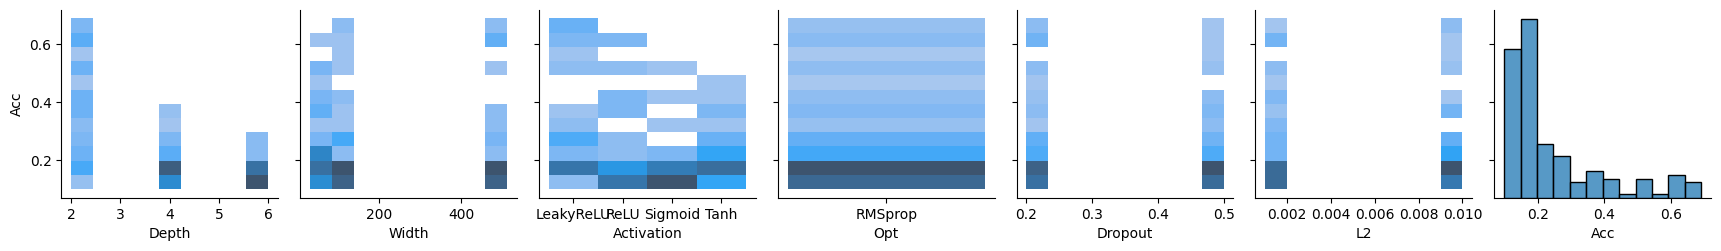

In [69]:
for opt in optimizers.keys():
    sns.pairplot(df_cleaned[df_cleaned['Opt'] == opt], y_vars=['Acc'], x_vars=df_cleaned.columns, kind='hist')
plt.show()

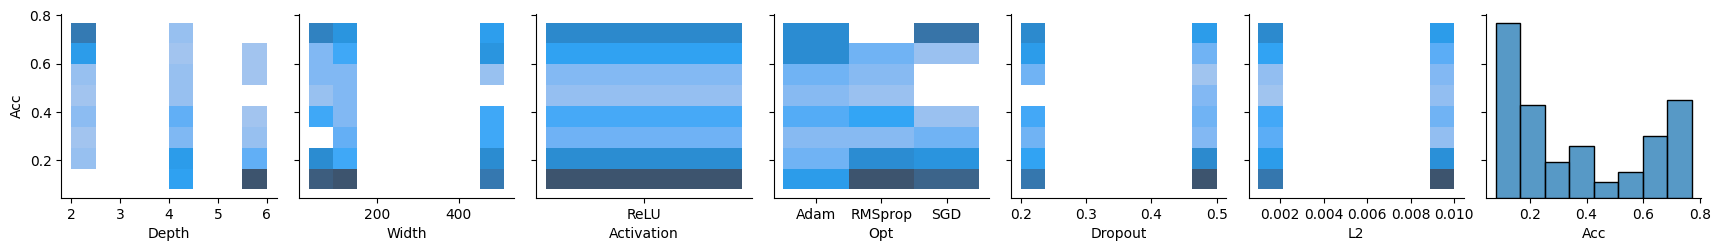

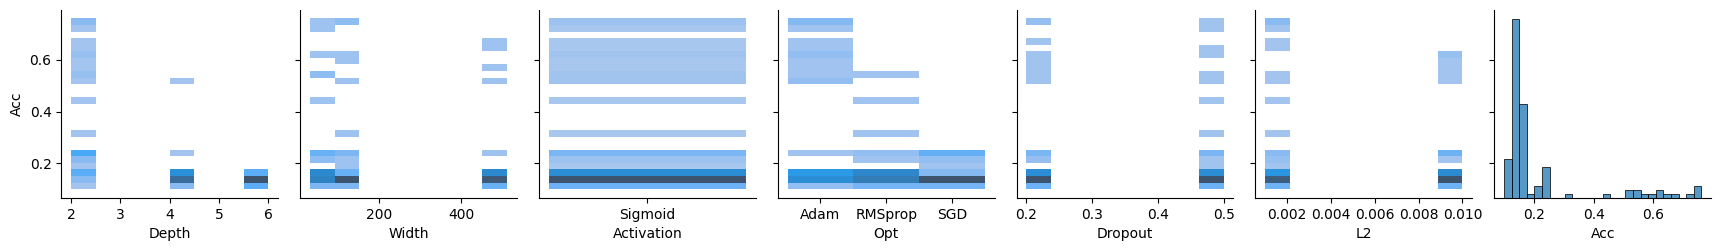

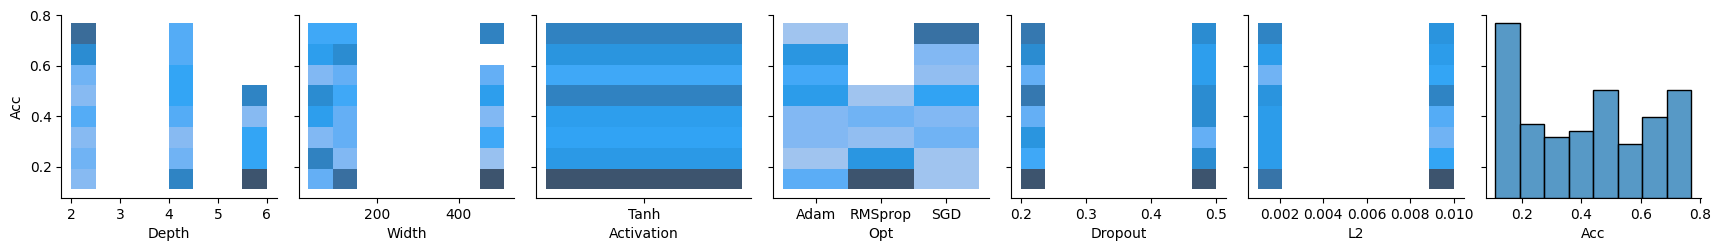

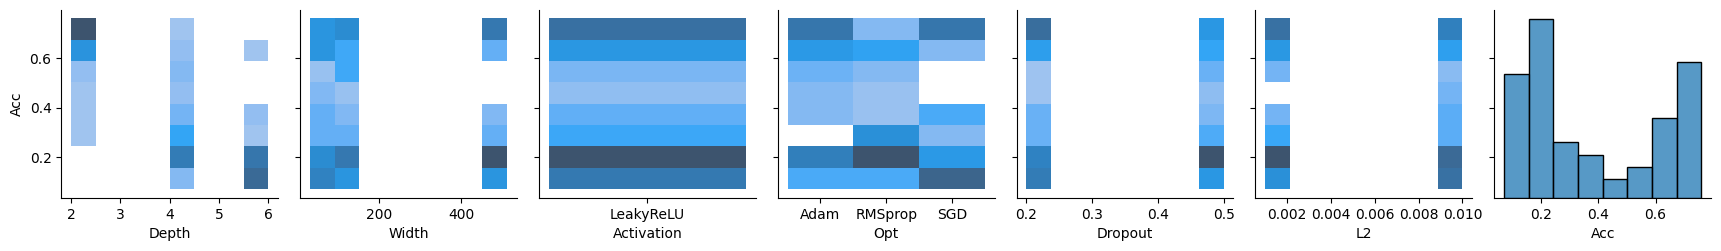

In [70]:
for activation in activation_functions.keys():
    sns.pairplot(df_cleaned[df_cleaned['Activation'] == activation], y_vars=['Acc'], x_vars=df_cleaned.columns, kind='hist')
plt.show()

In [20]:
corr = df_cleaned.corr()
corr.style.background_gradient(cmap='coolwarm')

,Depth,Width,Activation,Opt,Dropout,L2,Acc
Depth,1.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.640066
Width,-0.000000,1.000000,-0.000000,-0.000000,0.000000,0.000000,-0.037321
Activation,0.000000,-0.000000,1.000000,0.000000,0.000000,0.000000,0.125097
Opt,-0.000000,-0.000000,0.000000,1.000000,-0.000000,0.000000,-0.209981
Dropout,0.000000,0.000000,0.000000,-0.000000,1.000000,0.000000,-0.082152
L2,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.073172
Acc,-0.640066,-0.037321,0.125097,-0.209981,-0.082152,-0.073172,1.000000


Trends:
* Less depth works better here, probably model has not the best lr and epoch count for such deep model
* But it's absolutely enough for width, 512 yields better results more often
* Activations seem to clusterize, tanh works the best while relu/leaky_relu works the worst, while more consistently
* SGD takes the top spot, but the last too, Adam is more consistent
* 0.2 Dropout works better
* 0.001 Regularization yields more positive results
* Depth is the most crucial parameter here, optimizer is second

2. Checking three early stopping strategies

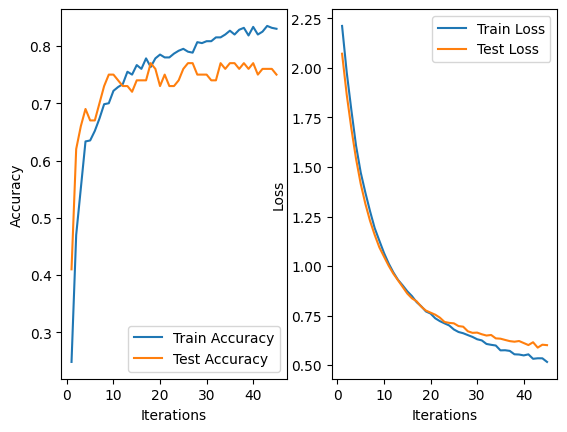

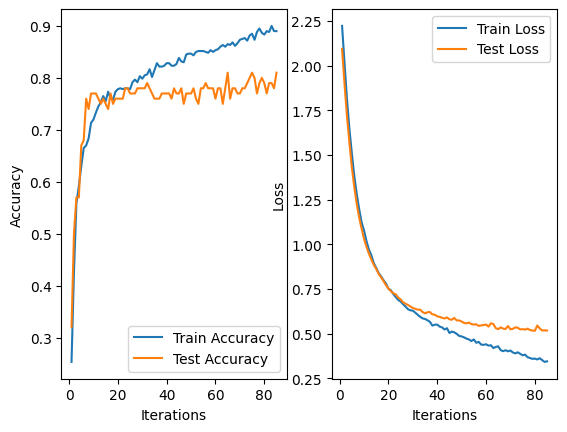

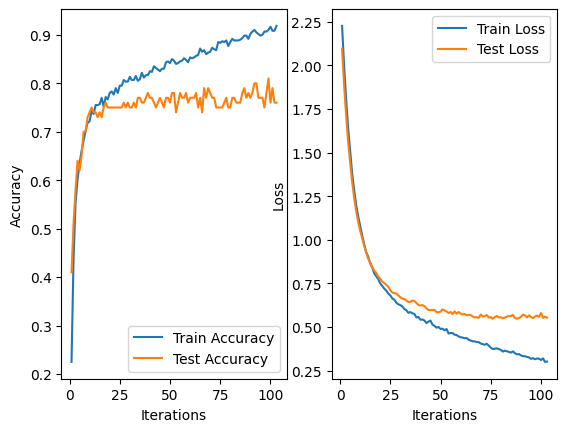

In [49]:
for patience in [2, 5, 15]:
    acc, history = train_and_evaluate(2, 512, 'Tanh', 128, 'SGD', dropout=0.2, early_stopping_patience=patience, l2_lambda=0.001, max_epochs=200)
    
    plot_history(history)

Low patience results in training halting too early
Medium patience seems much reasonable, protecting the model from overfitting
High patience leads to somewhat LateStopping 🗿🗿🗿

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Depth       432 non-null    int64  
 1   Width       432 non-null    int64  
 2   Activation  432 non-null    object 
 3   Batch       432 non-null    int64  
 4   Opt         432 non-null    object 
 5   Dropout     432 non-null    float64
 6   L2          432 non-null    float64
 7   Epochs      432 non-null    int64  
 8   Patience    432 non-null    int64  
 9   Acc         432 non-null    float64
 10  History     432 non-null    object 
dtypes: float64(3), int64(5), object(3)
memory usage: 37.2+ KB
None

First few rows:
   Depth  Width Activation  Batch   Opt  Dropout     L2  Epochs  Patience  \
0      2     32       ReLU    128   SGD      0.2  0.001      30         5   
1      2     32       ReLU    128   SGD      0.2  0.010      30         5   
2      2     32       ReLU  

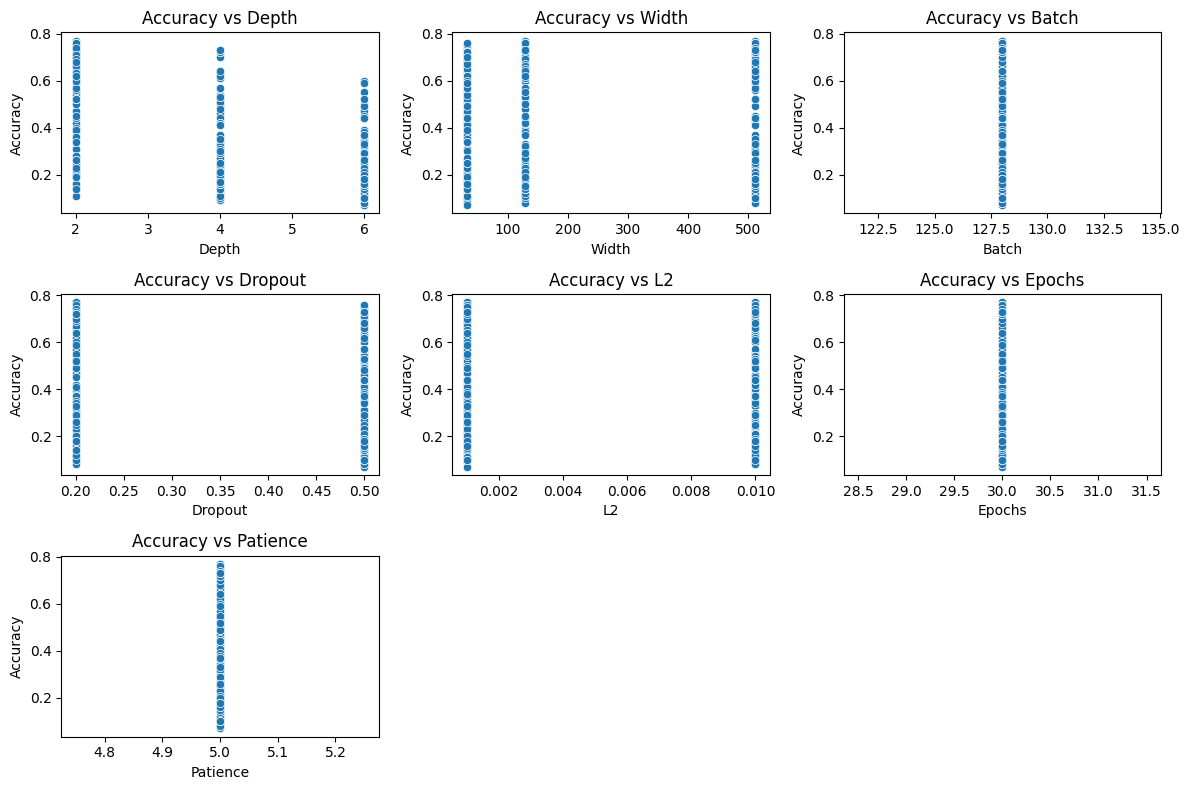

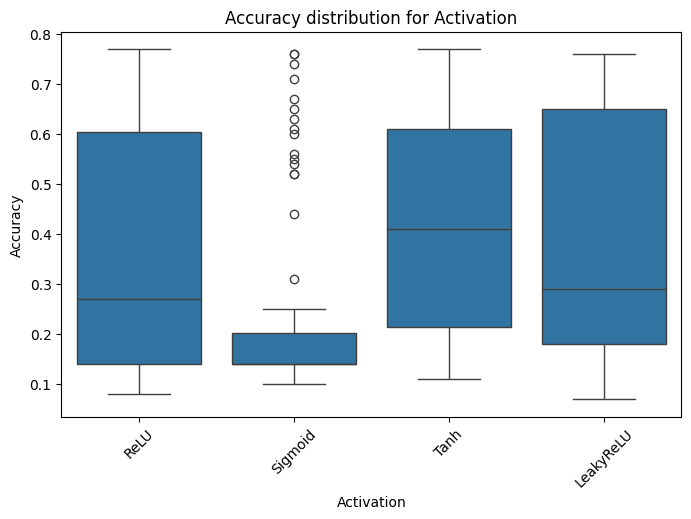

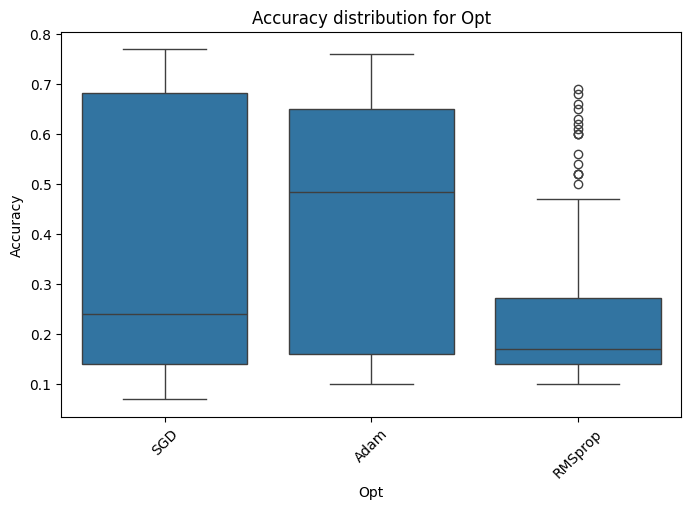

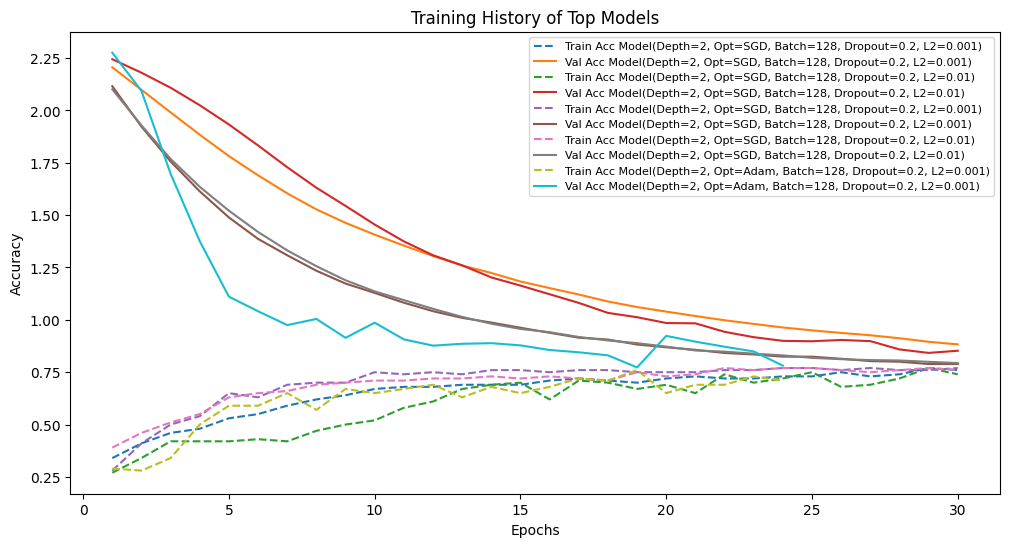

In [12]:
df = pd.read_csv('data/c_5_lab_1_out.csv')

numerical_cols = ['Depth', 'Width', 'Batch', 'Dropout', 'L2', 'Epochs', 'Patience']

plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=df[col], y=df["Acc"])
    plt.xlabel(col)
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy vs {col}")

plt.tight_layout()
plt.show()

categorical_cols = ["Activation", "Opt"]
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[col], y=df["Acc"])
    plt.xlabel(col)
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy distribution for {col}")
    plt.xticks(rotation=45)
    plt.show()

top_models = df.nlargest(5, 'Acc')

plt.figure(figsize=(12, 6))
for _, row in top_models.iterrows():
    history = ast.literal_eval(row["History"])
    epochs = list(range(1, len(history) + 1))

    train_acc = [x[2] for x in history]
    val_acc = [x[3] for x in history]

    model_desc = (f"Model(Depth={row['Depth']}, Opt={row['Opt']}, "
                  f"Batch={row['Batch']}, Dropout={row['Dropout']}, L2={row['L2']})")

    plt.plot(epochs, train_acc, linestyle="--", label=f"Train Acc {model_desc}")
    plt.plot(epochs, val_acc, label=f"Val Acc {model_desc}")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training History of Top Models")
plt.legend(fontsize=8)
plt.show()

Функції активації:

Sigmoid не підходить для цього завдання – точність значно нижча, а також стабільність - не дуже.


ReLU і LeakyReLU – ймовірно, найкращий вибір для цієї задачі, оскільки вони стабільно досягають високих значень.



Оптимізатори:

Adam – найкращий вибір. Він дає стабільні високі результати.
SGD може працювати добре, але потребує тонкої настройки. Якщо правильно підібрати гіперпараметри, можна отримати високу точність, але в середньому він менш стабільний.
RMSprop працює найгірше у нашому випадку

Загальні тенденції (за останнім графіком):

На початку тренування точність (accuracy) швидко зростає, але потім виходить на плато.

Помітно, що для деяких моделей розрив між Train Acc і Val Acc значний, що є ознакою перенавчання.

Тобто, моделі мають занадто високу складність і погано узагальнюють дані.

Але моделі із топовими параметрами демонструють хорошу генералізацію.


Деякі моделі швидко досягають насичення точності, інші мають більш поступове покращення. Це може залежати від всіх параметрім моделі, але більш за все - від вибору оптимізатора: Adam зазвичай має швидший вихід на плато, а SGD може показувати більш повільний, але стабільний ріст.


Загалом, валідаційна точність усіх моделей виходить на рівень близько 0.7–0.8.

